In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:98% !important; }</style>"))
# display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
import os
%cd /home/mila/l/limjaehy/projs/func-sdeflow-dev-jmlr

/home/mila/l/limjaehy/projs/func-sdeflow-dev-jmlr


In [3]:
import importlib, sys
import functools
import math

import numpy as np

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

MYBACKEND = plt.get_backend()
print(MYBACKEND)

%matplotlib inline

module://matplotlib_inline.backend_inline


In [4]:
from utils.visualize import *
matplotlib.use(MYBACKEND)

In [5]:
from main import *

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_million(model):
    return int( count_parameters(model) / 1e6 )

use gpu



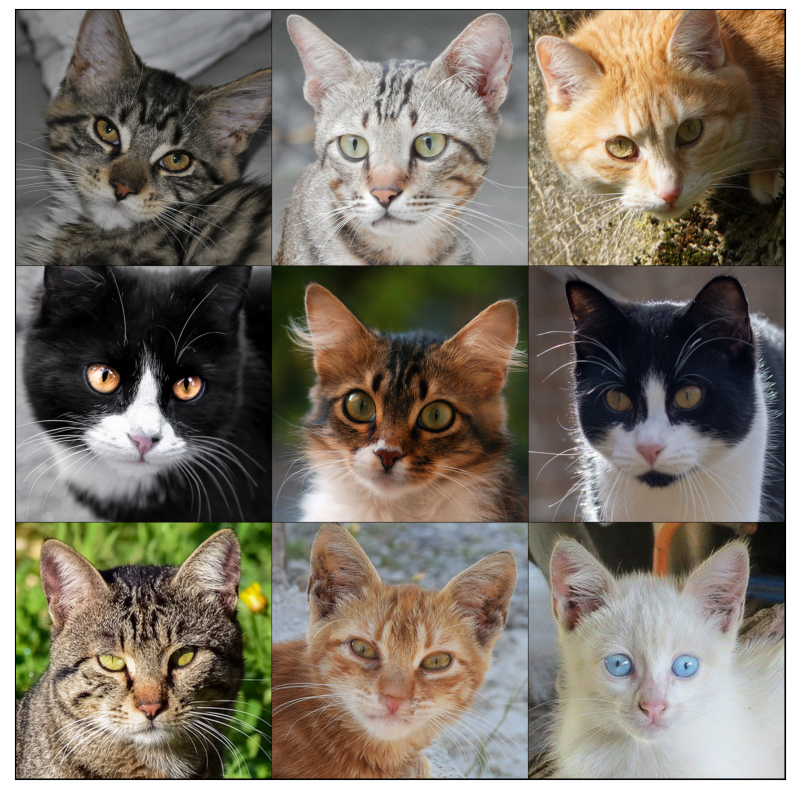

In [7]:
import os
import argparse

from utils import datasets
# from utils.visualize import plot_scatter, plot_contourf

nrow = 3
batch_size = nrow**2

# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
else:
    device = 'cpu'
    print('use cpu\n')

# init dataset
train_loader, _, _ = datasets.get_loaders_eval(
    dataset='afhqv2_cat_1024', #'ffhq_1024',
    root='/home/mila/l/limjaehy/scratch/data', #'/network/datasets/ffhq',
    distributed=False,
    batch_size=batch_size,
    centered=False,
    num_workers=1,
    shuffle_train=False,
)

# fetch
train_iter = iter(train_loader)
x, _ = next(train_iter)
x, _ = next(train_iter)
x = x * 255 / 256 + torch.rand_like(x) / 256 # dequantize
x = x.to(device)

plt.figure(figsize=(10,10))
plt.imshow(
    get_grid_image(x[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=2, normalize=False, to_numpy=True)
)
plt.xticks([])
plt.yticks([])
plt.show()


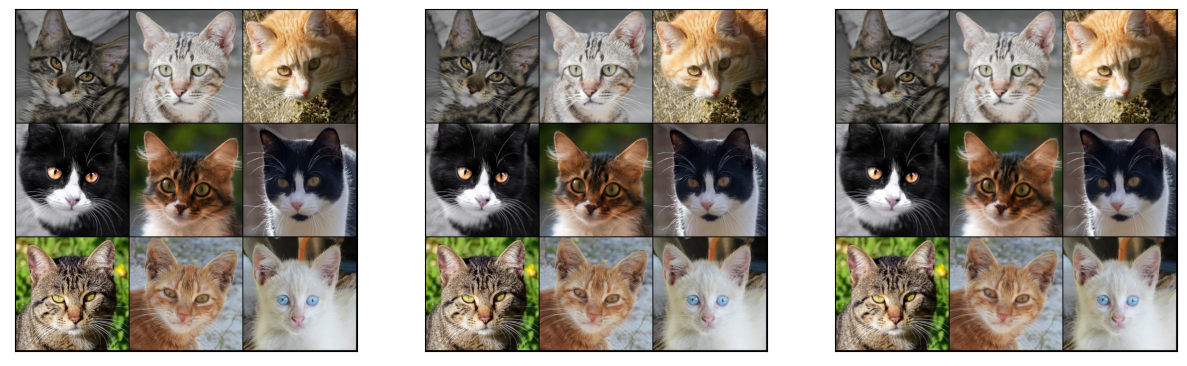

In [8]:
from lib.models.aliasfree_dct import Upsample2d, Downsample2d
down2 = Downsample2d(
    scale_factor=0.5,
    filter_size=9,
    use_radial=False,
).to(device)
down4 = Downsample2d(
    scale_factor=0.25,
    filter_size=9,
    use_radial=False,
).to(device)

# from lib.models.upsample import Upsample2d, Downsample2d
# down2 = Downsample2d(2).to(device)
# down4 = Downsample2d(4).to(device)

x1 = x
x2 = down2(x1).clip(0,1)
x4 = down4(x1).clip(0,1)


plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15,10))

axes[0].imshow(
    get_grid_image(x1[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=8, normalize=False, to_numpy=True)
)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(
    get_grid_image(x2[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=4, normalize=False, to_numpy=True)
)
axes[1].set_xticks([])
axes[1].set_yticks([])


axes[2].imshow(
    get_grid_image(x4[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=2, normalize=False, to_numpy=True)
)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

In [9]:
height1 = x1.shape[-1]
height2 = x2.shape[-1]
height4 = x4.shape[-1]
print(height1, height2, height4)

1024 512 256


In [10]:
import time
import argparse


# init
cuda = True
args = argparse.Namespace()


# dataset
args.in_channels = 2
args.out_channels = 3
x_train = x4
args.train_img_height = x_train.shape[-1]
args.base_resolution = args.train_img_height // 2
args.forward = forward = to_center
args.reverse = reverse = to_01_clip

# train
args.batch_size = 1
args.lr = 1e-4 #0.001
args.lr_min = 1e-5 #1e-4
args.max_norm = 1.0
args.num_iters = 5000
args.warmup_iters = 1000
args.print_every = 100

# train
args.batch_size = 1
args.lr = 1e-4 #0.001
args.lr_min = 1e-5 #1e-4
args.max_norm = 1.0
args.num_iters = 5000
args.warmup_iters = 1000
args.print_every = 100


# get model
from lib.models.sparse_unet import SparseUNet, rearrange, repeat
from lib.models.contconv import get_coords, get_batch
args.ch = 32 #64 #128
args.ch_mult = (1,2,2,2,2) #(1,2,2,2)
args.num_res_blocks = 2 #4
args.dropout = 0.
model = SparseUNet(   
    channels=args.in_channels,
    out_channels=args.out_channels,
    nf=args.ch,
    time_emb_dim=16,
    img_size=args.base_resolution, backend="torch_geometric",
    # img_size=args.base_resolution, backend="torchsparse",
    num_conv_blocks=args.num_res_blocks,
    knn_neighbours=3,
    uno_res=128, #64,
    uno_mults=args.ch_mult,
    z_dim=None,
    conv_type="conv",
    kernel_size=7,
    optimise_dense=False, #True,
    blocks_per_level=tuple([args.num_res_blocks]*len(args.ch_mult)),
    attn_res=[], #[16,8],
    dropout_res=16,
    dropout=args.dropout,
    uno_base_nf=args.ch,
    depthwise_sparse=True,
    fc_channels=32,
)
print(model)
print( f'# params: {count_parameters_million(model)}M' )
print()

if cuda:
    model = model.cuda()

# optimizer
optim = torch.optim.Adam(model.parameters(), lr=args.lr)

# lr scheduler
if args.warmup_iters > 0:
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optim,
        T_max=float(args.num_iters - args.warmup_iters - 1),
        eta_min=args.lr_min,
    )
else:
    lr_scheduler = None

# training
ind = 1 #5
y = args.forward(x_train[ind:ind+args.batch_size])
v = get_mgrid(args.in_channels, args.train_img_height).repeat(args.batch_size, 1, 1, 1)
t = torch.zeros(args.batch_size,)
if cuda:
    v = v.cuda()
    y = y.cuda()
    t = t.cuda()
model.train()
start_time = time.time()
for count in range(args.num_iters):
    if lr_scheduler is not None and count+1 > args.warmup_iters:
        lr_scheduler.step()
    optim.zero_grad()

    sample_lst = torch.stack([torch.from_numpy(np.arange(args.train_img_height**2)) for _ in range(args.batch_size)]).to(v.device)
    # q_sample = (args.train_img_height ** 2) // 2
    # sample_lst = torch.stack([torch.from_numpy(np.random.choice(args.train_img_height**2, q_sample, replace=False)) for _ in range(args.batch_size)]).to(v.device)

    v_sampled = rearrange(v, 'b c h w -> b (h w) c')
    v_sampled = torch.gather(v_sampled, 1, sample_lst.unsqueeze(2).repeat(1,1,v_sampled.size(2))).contiguous()
    y_sampled = rearrange(y, 'b c h w -> b (h w) c')
    y_sampled = torch.gather(y_sampled, 1, sample_lst.unsqueeze(2).repeat(1,1,y_sampled.size(2))).contiguous()

    pred = model(v_sampled, t, sample_lst=sample_lst, img_size=args.train_img_height)

    loss = ((y_sampled - pred)**2).mean()

    # backward
    loss.backward()

    # gradient clipping
    if args.max_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)

    # update
    optim.step()

    # print
    if (count == 0) or (count+1) % args.print_every == 0:
        elapsed = (time.time() - start_time) / args.print_every * 1000
        start_time = time.time()
        _lr = lr_scheduler.get_last_lr()[-1] if lr_scheduler is not None else args.lr
        print('iter: {:5d} | time: {:7.2f} ms | loss: {:7.2f} | lr {:7.5f}'.format(count+1, elapsed, loss.item() * 1000, _lr))


SparseUNet(
  (linear_in): Linear(in_features=2, out_features=32, bias=True)
  (linear_out): Linear(in_features=32, out_features=3, bias=True)
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=16, out_features=16, bias=True)
  )
  (down_blocks): ModuleList(
    (0): SparseConvResBlock(
      (block): TorchGeometricResBlock(
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (conv): ContinuousConv2d(
          bs = 128, 
          in_channels = 32, 
          out_channels = 32, 
          embed_channels = 32, 
          fc_channels = 32, 
          kernel_size = 7, 
          groups = 32, 
          bias = True, 
          weight_net = Sequential(
          (0): Scale(init=100.0)
          (1): Linear(in_features=2, out_features=32, bias=True)
          (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

iter:     1 | time:    9.79 ms | loss:  290.69 | lr 0.00010
iter:   100 | time:  527.02 ms | loss:   79.67 | lr 0.00010
iter:   200 | time:  532.22 ms | loss:   46.63 | lr 0.00010
iter:   300 | time:  532.15 ms | loss:   20.85 | lr 0.00010
iter:   400 | time:  532.08 ms | loss:   13.13 | lr 0.00010
iter:   500 | time:  532.13 ms | loss:    7.61 | lr 0.00010
iter:   600 | time:  532.05 ms | loss:    6.56 | lr 0.00010
iter:   700 | time:  532.31 ms | loss:    5.63 | lr 0.00010
iter:   800 | time:  532.38 ms | loss:    5.58 | lr 0.00010
iter:   900 | time:  532.27 ms | loss:    5.14 | lr 0.00010
iter:  1000 | time:  532.33 ms | loss:    5.01 | lr 0.00010
iter:  1100 | time:  532.40 ms | loss:    5.00 | lr 0.00010
iter:  1200 | time:  532.58 ms | loss:    4.96 | lr 0.00010
iter:  1300 | time:  532.35 ms | loss:    4.63 | lr 0.00010
iter:  1400 | time:  532.30 ms | loss:    4.45 | lr 0.00010
iter:  1500 | time:  531.94 ms | loss:    4.22 | lr 0.00010
iter:  1600 | time:  531.88 ms | loss:  

In [11]:
import gc

del optim, pred
optim = None
pred = None

gc.collect()
torch.cuda.empty_cache()

!nvidia-smi

Wed Jan 22 00:22:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   42C    P0            105W /  500W |    1557MiB /  81920MiB |     45%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [12]:
from pytorch3d.ops import knn_points, knn_gather

def knn_interpolate(target_coords, source_x, source_coords, knn_neighbours=3):
    with torch.no_grad():
        _, assign_index, neighbour_coords = knn_points(target_coords.repeat(source_x.size(0),1,1), source_coords, K=knn_neighbours, return_nn=True)
        # neighbour_coords: (B, y_length, K, 2)
        diff = neighbour_coords - target_coords.unsqueeze(2) # can probably use dist from knn_points
        squared_distance = (diff * diff).sum(dim=-1, keepdim=True)
        weights = 1.0 / torch.clamp(squared_distance, min=1e-16) # (B, y_length, K, 1)

    # See Eqn. 2 in PointNet++. Inverse square distance weighted mean
    neighbours = knn_gather(source_x, assign_index) # (B, y_length, K, C) 
    out = (neighbours * weights).sum(2) / weights.sum(2)

    return out.to(source_x.dtype)


In [13]:
import tqdm

def get_pred_by_split(model, batch_size, in_channels, height, n_split):
    v = get_mgrid(in_channels, height).repeat(batch_size, 1, 1, 1)


    sample_lst_all = torch.stack([torch.from_numpy(np.random.permutation(height**2)) for _ in range(batch_size)]).to(v.device)
    q_sample = sample_lst_all.shape[-1] // n_split
    assert q_sample * n_split == sample_lst_all.shape[-1]

    sample_lst_batch = [sample_lst_all[:,i*q_sample:(i+1)*q_sample] for i in range(n_split)]

    t = torch.zeros(batch_size,)

    if cuda:
        v = v.cuda()
        sample_lst_all = sample_lst_all.cuda()
        sample_lst_batch = [sample_lst_.cuda() for sample_lst_ in sample_lst_batch]
        t = t.cuda()

    pred_sampled = []
    with torch.no_grad():
        for ind in tqdm.tqdm(range(n_split), ncols=68):

            v_sampled = rearrange(v, 'b c h w -> b (h w) c')
            v_sampled = torch.gather(v_sampled, 1, sample_lst_batch[ind].unsqueeze(2).repeat(1,1,v_sampled.size(2))).contiguous()

            pred_sampled_ = model(v_sampled, t, sample_lst=sample_lst_batch[ind], img_size=height).detach().data
            gc.collect()
            torch.cuda.empty_cache()

            pred_sampled += [pred_sampled_]

    pred_sampled = torch.cat(pred_sampled, dim=1)

    coords = get_coords(batch_size, height).to(v_sampled.device)
    coords_sampled = torch.gather(coords, 1, sample_lst_all.unsqueeze(2).repeat(1,1,coords.size(2))).contiguous()

    pred = knn_interpolate(coords, pred_sampled, coords_sampled, 1)
    pred = rearrange(pred, 'b (h w) c -> b c h w', h=height)

    gc.collect()
    torch.cuda.empty_cache()

    return pred


In [14]:
print(model.__class__.__name__)
print()

model.eval()

pred4 = get_pred_by_split(model, args.batch_size, args.in_channels, height4, n_split=1)
print(pred4.shape)

pred2 = get_pred_by_split(model, args.batch_size, args.in_channels, height2, n_split=2)
print(pred2.shape)

pred1 = get_pred_by_split(model, args.batch_size, args.in_channels, height1, n_split=8)
print(pred1.shape)


SparseUNet



100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


torch.Size([1, 3, 256, 256])


100%|█████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


torch.Size([1, 3, 512, 512])


100%|█████████████████████████████████| 8/8 [00:08<00:00,  1.04s/it]


torch.Size([1, 3, 1024, 1024])


diff 1:   3.529
diff 2:   2.260
diff 4:   0.481


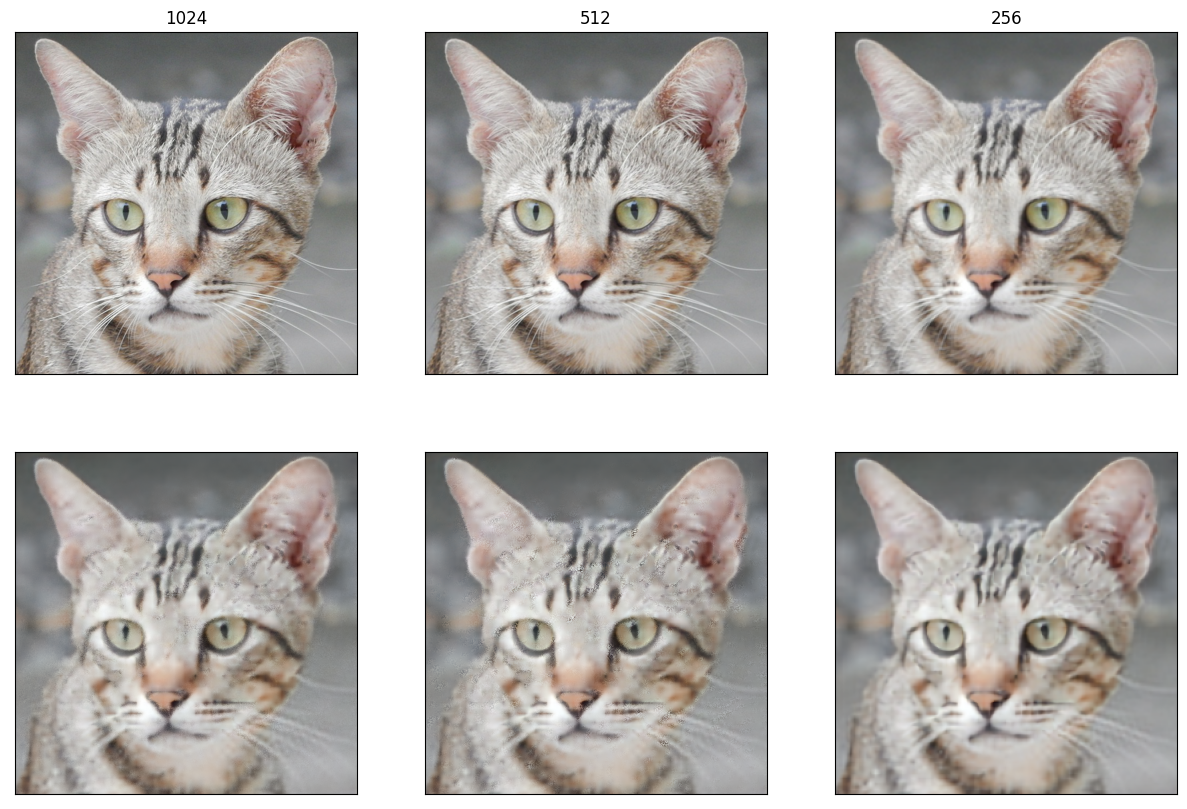

In [15]:

diff1 = ((x1[ind:ind+1] - args.reverse(pred1))**2).mean().item() * 1000
print('diff 1: {:7.3f}'.format(diff1))
diff2 = ((x2[ind:ind+1] - args.reverse(pred2))**2).mean().item() * 1000
print('diff 2: {:7.3f}'.format(diff2))
diff4 = ((x4[ind:ind+1] - args.reverse(pred4))**2).mean().item() * 1000
print('diff 4: {:7.3f}'.format(diff4))

plt.close('all')
fig, axes = plt.subplots(2, 3, figsize=(15,10))

axes[0,0].imshow(
    get_grid_image(x1[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,0].set_title(f'{height1}')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,1].imshow(
    get_grid_image(x2[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,1].set_title(f'{height2}')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,2].imshow(
    get_grid_image(x4[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,2].set_title(f'{height4}')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])

axes[1,0].imshow(
    get_grid_image(args.reverse(pred1)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,1].imshow(
    get_grid_image(args.reverse(pred2)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,2].imshow(
    get_grid_image(args.reverse(pred4)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])
plt.show()

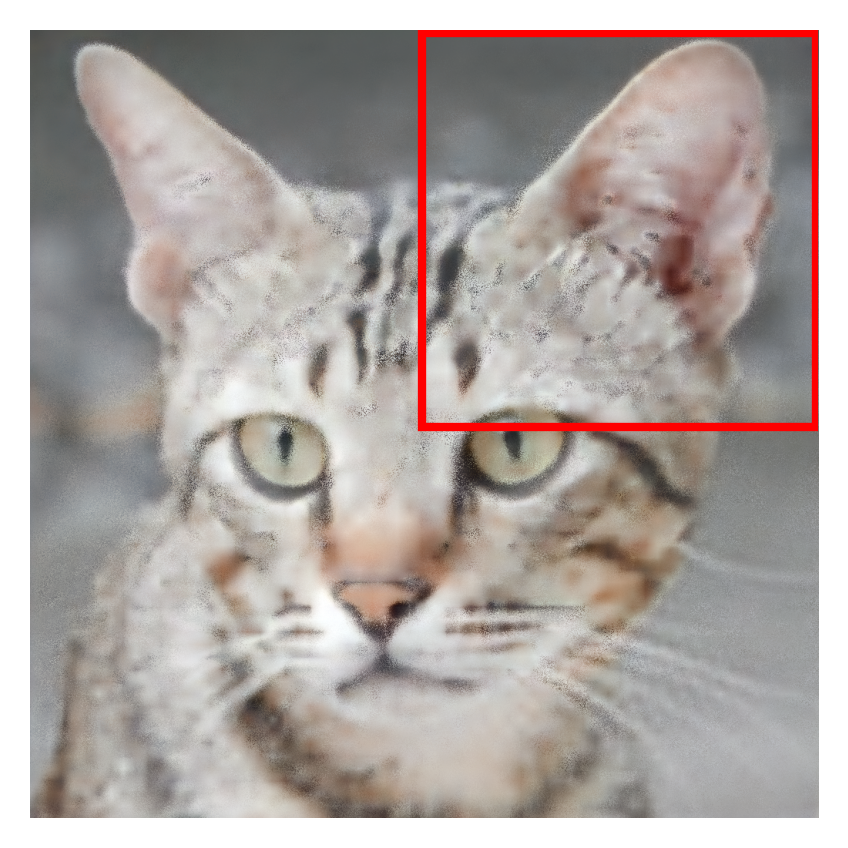

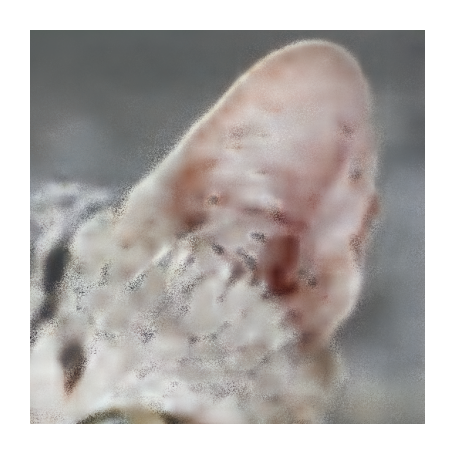

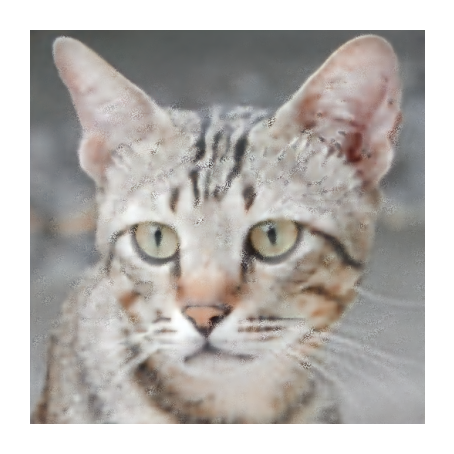

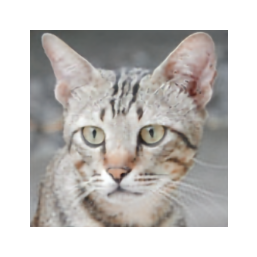

In [16]:
from matplotlib.patches import Rectangle

def save_image(image, model_name, my_dpi=300, add_rect=False):
    height = image.shape[0]
    width = image.shape[1]
    plt.figure(figsize=(height/my_dpi, width/my_dpi), dpi=my_dpi)
    plt.imshow(image)
    ax = plt.gca()
    ax.axis(False)
    if add_rect:
        half_height = height//2
        half_width = width//2
        # rect = Rectangle((half_height-4,half_width-4),half_height,half_width,linewidth=2,edgecolor='r',facecolor='none')
        rect = Rectangle((half_height-4,4),half_height,half_width,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        # patch = image[half_height:,half_width:]
        patch = image[:half_height,half_width:]
    plt.savefig(f'samples/fitting_{model_name}_{height}x{width}.pdf', dpi=my_dpi, bbox_inches='tight', transparent=True, pad_inches=0.0)
    plt.show()
    if add_rect:
        plt.figure(figsize=(half_height/my_dpi, half_width/my_dpi), dpi=my_dpi)
        plt.imshow(patch)
        ax = plt.gca()
        ax.axis(False)
        plt.savefig(f'samples/fitting_{model_name}_{height}x{width}_patch.pdf', dpi=my_dpi, bbox_inches='tight', transparent=True, pad_inches=0.0)
        plt.show()
    return None

save_image(get_grid_image(args.reverse(pred1)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='sparse_unet_cc_det', my_dpi=300, add_rect=True)
save_image(get_grid_image(args.reverse(pred2)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='sparse_unet_cc_det', my_dpi=300)
save_image(get_grid_image(args.reverse(pred4)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='sparse_unet_cc_det', my_dpi=300)

plt.close('all')